In [ ]:
!pip install -q -U albumentations
!echo "$(pip freeze | grep albumentations) is successfully installed"

     |████████████████████████████████| 102kB 6.0MB/s 
     |████████████████████████████████| 38.2MB 78kB/s 
albumentations==1.0.1 is successfully installed


In [ ]:
import torch
import torch.optim as optim
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
import random
from PIL import Image
import albumentations as A
import shutil
import os
import matplotlib.pyplot as plt
from tqdm import trange
import cv2
from albumentations.pytorch import ToTensorV2

In [ ]:
train_dir = Path('drive/MyDrive/casting_data/train')
test_dir = Path('drive/MyDrive/casting_data/test')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Копирование в дисковое пространство Google Collab

In [ ]:
os.makedirs('casting_data/train')
os.makedirs('casting_data/test')
train_files = np.array(list(train_dir.rglob('*.jpeg')))
for i in range(len(train_files)):
        shutil.copyfile(str(train_files[i]), 
                        'casting_data/train'+'/'+train_files[i].name[:-5]+'copy.jpeg')
test_files = np.array(list(test_dir.rglob('*.jpeg')))
for i in range(len(test_files)):
        shutil.copyfile(str(test_files[i]), 
                        'casting_data/test'+'/'+test_files[i].name[:-5]+'copy.jpeg')

###Увеличение объёма данных

In [ ]:
img_size = 300
growth_rate = 0.5

In [ ]:
def clone_data(path): 
          files_names = np.array(list(path.rglob('*.jpeg')))
          length = len(files_names)
          for i in range(int(length*growth_rate)):
               idx = random.randint(1,length-1)
               #os.system(' copy '+str(files_names[idx])+' '
               #+'casting_data/train'+'/'+train_files[idx].name[:-5]+'copy.jpeg')
               shutil.copyfile(str(files_names[idx]), 
               'casting_data/train'+'/'+train_files[idx].name[:-5]+'copy2.jpeg')

In [ ]:
train_dir = Path('casting_data/train')
test_dir = Path('casting_data/test')

In [ ]:
clone_data(train_dir)

###Загрузка файлов и перемешивание файлов в списке

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
train_val_files = np.array(list(train_dir.rglob('*.jpeg')))
test_files = np.array(list(test_dir.rglob('*.jpeg')))
train_val_labels = le.fit_transform([path.name[:8] for path in train_val_files])
test_labels = le.fit_transform([path.name[:8] for path in test_files])

In [ ]:
train_val_inds = np.arange(len(train_val_files))
random.shuffle(train_val_inds)
test_inds = np.arange(len(test_files))
random.shuffle(test_inds)
train_val_files=train_val_files[train_val_inds]
train_val_labels=train_val_labels[train_val_inds]
test_files=test_files[test_inds]
test_labels=test_labels[test_inds]

###Деление на train и validation

In [ ]:
!pip install torchvision
import torchvision

In [ ]:
from sklearn.model_selection import train_test_split
train_files, val_files, train_labels, val_labels = train_test_split(train_val_files, train_val_labels, test_size=0.25, stratify=train_val_labels)

In [ ]:
class DatasetCreator(Dataset):
      def __init__(self, x_data, y_data, transform):
          super().__init__()
          self.data = x_data
          self.labels = y_data
          self.transform = transform

      def __len__(self):
          return len(self.data)

      def __getitem__(self, index):
          x = cv2.imread(str(self.data[index]))
          x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
          random.seed(23) 
          if self.transform is not None:
             x = self.transform(image=x)['image']
          y = self.labels[index]
          return x, y

      def visualize(self, index):
          x = cv2.imread(str(self.data[index]))
          x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
          plt.figure(figsize=(10, 10))
          plt.axis('off')
          plt.imshow(x)

      def get_image(self, index):
          x = cv2.imread(str(self.data[index]))
          x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
          random.seed(23) 
          if self.transform is not None:
             x = self.transform(image=x)['image']
          return x
          
      def get_answer(self, index):
          return self.labels[index]

###Обучение

In [ ]:
!pip install neptune-client

     |████████████████████████████████| 245kB 8.0MB/s 
     |████████████████████████████████| 829kB 49.8MB/s 
     |████████████████████████████████| 71kB 9.5MB/s 
     |████████████████████████████████| 174kB 54.0MB/s 
     |████████████████████████████████| 71kB 11.7MB/s 
     |████████████████████████████████| 133kB 54.9MB/s 
     |████████████████████████████████| 71kB 12.6MB/s 
  Created wheel for neptune-client: filename=neptune_client-0.10.0-py2.py3-none-any.whl size=424759 sha256=6ca9a443abb6f72b31902381682e3a923e30302b3fb1c6da32a8f337b7fe9c61
  Stored in directory: /root/.cache/pip/wheels/72/fa/50/8228b7a67ab5fb2a3f743da508e49f84cb48923d860ab9c942
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491070 sha256=8c5e7bc1c8c59e7158f3d84b0ce158184df7d743302d3d601e60a9df8b128620
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for strict-rfc3339: filename=strict_rfc3339-0.7-cp37-none-

In [ ]:
from torch.optim import lr_scheduler
import torch.optim as optim
import tqdm
import neptune.new as neptune
run = neptune.init(
    api_token= os.getenv('NEPTUNE_API_TOKEN'),
    project = 'misha/first-proj'
)

https://app.neptune.ai/misha/first-proj/e/FIR-31
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [ ]:
transform = A.Compose([
                      A.Resize(256,256),
                      A.Rotate(limit = 180, p = 0.3),
                      A.HorizontalFlip(p=0.3),
                      A.VerticalFlip(p=0.3),
                      A.PadIfNeeded(min_height=255,min_width=255,border_mode=2),
                      A.RGBShift(p=0.5),
                      A.HueSaturationValue(p=0.3,hue_shift_limit=10, sat_shift_limit=10, val_shift_limit=10),
                      A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                      ToTensorV2(),
                      
])

train_dataset = DatasetCreator(train_files, train_labels, transform)
val_dataset = DatasetCreator(val_files, val_labels, transform)

In [ ]:
def train(train_dataset, val_dataset, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    opt = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()
    scheduler = lr_scheduler.ExponentialLR(opt, gamma=0.85)####
        
    run['model/parameters/n_epochs'] = epochs
        
    for epoch in trange(epochs, desc="Epoch:"):
        train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt, scheduler)
        val_loss, val_acc = eval_epoch(model, val_loader, criterion)
        run['train/epoch/loss'].log(train_loss)
        run['train/epoch/accuracy'].log(train_acc)
                      

In [ ]:
def fit_epoch(model, train_loader, criterion, opt, scheduler):
    total_acc=0
    total_loss=0
    num_pictures=0
    num_batches=0
    scheduler.step()
    for x_train, y_train in train_loader:
        x_train = x_train.to(torch.device("cuda"))
        y_train = y_train.to(torch.device("cuda"))
        opt.zero_grad()
        predictions = model(x_train)
        loss = criterion(predictions, y_train)
        loss.backward()
        opt.step()
        
        pred_labels = torch.argmax(predictions, 1)
        total_acc += torch.sum(pred_labels == y_train)
        total_loss += loss.item() #mean loss for batch
        num_pictures += len(y_train) #number of pictures
        num_batches += 1 #number of batches
        run["train/accuracy"].log(torch.sum(pred_labels == y_train)/len(y_train))
        run["train/loss"].log(loss.item())
    return total_loss/num_batches, total_acc/num_pictures


In [ ]:
def eval_epoch(model, val_loader, criterion):
    total_acc=0
    total_loss=0
    num_pictures=0
    num_batches=0
    for x_train, y_train in val_loader:
        x_train = x_train.to(torch.device("cuda"))
        y_train = y_train.to(torch.device("cuda"))
        with torch.no_grad():
             predictions = model(x_train)
             loss = criterion(predictions, y_train)
             pred_labels = torch.argmax(predictions, 1)

             total_acc += torch.sum(pred_labels == y_train)
             total_loss += loss.item() #mean loss for batch
             num_pictures += len(y_train) #number of pictures
             num_batches += 1 #number of batches
             run["evaluation/accuracy"].log(torch.sum(pred_labels == y_train)/len(y_train))
             run["evaluation/loss"].log(loss.item())
    return total_loss/num_batches, total_acc/num_pictures

In [ ]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-cp37-none-any.whl size=16443 sha256=f279ea53c8fcf3bc7dc40c186351547d8be0c35812eaaa89315539ceec0c88ae
  Stored in directory: /root/.cache/pip/wheels/84/27/aa/c46d23c4e8cc72d41283862b1437e0b3ad318417e8ed7d5921
Successfully built efficientnet-pytorch


In [ ]:
from torchvision import models
import torch.nn as nn
from torchvision import transforms
from efficientnet_pytorch import EfficientNet

In [ ]:
model = EfficientNet.from_pretrained('efficientnet-b5')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b5-b6417697.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b5-b6417697.pth



Loaded pretrained weights for efficientnet-b5


In [ ]:
model

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, kernel_siz

In [ ]:
for param in  model.parameters():
    param.requires_grad=False
for param in model._blocks[30:].parameters():
    param.requires_grad=True
model._conv_head.requires_grad=True
model._bn1.requires_grad=True
model._avg_pooling.requires_grad=True
model._dropout.requires_grad=True
model._fc.requires_grad=True

In [ ]:
n_classes = 2
num_features = 2048

In [ ]:
model._fc = nn.Linear(in_features=num_features, out_features=n_classes)

In [ ]:
if torch.cuda.is_available():
    model = model.cuda()

In [ ]:
train(train_dataset, val_dataset, model, 9, 64)

Epoch::   0%|          | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
Epoch:: 100%|██████████| 9/9 [48:59<00:00, 326.62s/it]


In [ ]:
testdataset = DatasetCreator(test_files, test_labels, transform)

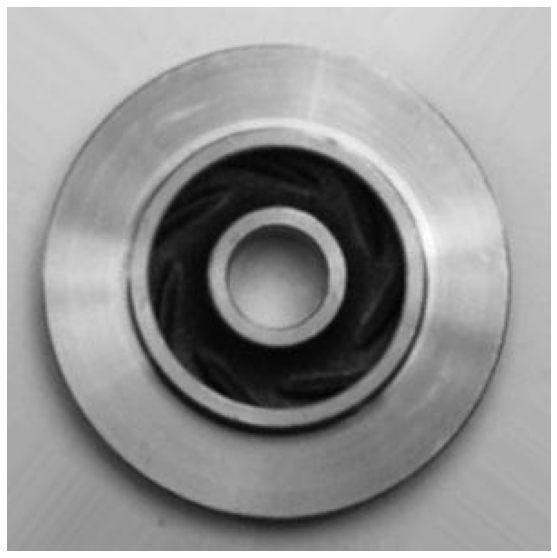

In [ ]:
testdataset.visualize(205)

In [ ]:
model.eval()
x = testdataset.get_image(205).unsqueeze(0)
x = x.to(torch.device("cuda"))
with torch.no_grad():
  res = model(x).cpu()
  probs = nn.functional.softmax(res, dim=-1).numpy()
  prediction = np.argmax(probs,-1)

In [ ]:
prediction

array([1])

In [ ]:
testdataset.get_answer(205)

0

In [ ]:
def visualize(image):
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(image)

In [ ]:
def predict(model, test_files):
    with torch.no_grad():
         results = []
         for img in test_files:
            x = cv2.imread(str(img))
            x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
            x = np.array(x / 255, dtype='float32')
            transform = A.Compose([
                                    A.Resize(256,256),
                                    ToTensorV2(),
            ])
            x = transform(image=x)['image']
            
            x = x.to(torch.device("cuda")).unsqueeze(0)
            model.eval()
            preds = model(x).cpu()
            results.append(preds)
    probs = nn.functional.softmax(torch.cat(results), dim=-1).numpy()
    return probs
  
probs=predict(model, test_files)
y_preds = np.argmax(probs,-1)

In [ ]:
def predict(model, testdataset):
    with torch.no_grad():
        preds = []
    
        for i in range(0, len(test_files)):
            x = testdataset.get_image(i).unsqueeze(0)
            x = x.to(torch.device("cuda"))
            model.eval()
            res = model(x).cpu()
            probs = nn.functional.softmax(res, dim=-1).numpy()
            preds.append(int(np.argmax(probs,-1)))
            
    return preds

In [ ]:
preds = predict(model, testdataset)
preds

[0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,


In [ ]:
for i in range(len(preds)):
    if (preds[i]!=test_labels[i]): 
        print(i)

20
205


In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(test_labels,preds)

0.9970501474926253